# Introduction to Reinforcement Learning with Python

In this tutorial we will explore about some essencial notions about reinforcement learning, some useful tools and what is still missing.

- The reinforcement learning framework.
- Markov decision process.
- Q-learning algorithm
- Conclusions
- Open challenges

Created by [Angel Ayala](https://github.com/angel-ayala/) for the Scientific Computing Summer School 2021, 20 - 24 Sept, 2021.


In [1]:
#@title Helpers
import random
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets       # interactive display


seed_val = 202109


def run_ep(agent, env, epsilon=0.99, function_update=None, gamma=0., alpha=0.):
    """Auxiliary function to run an episode until the end flag is True.

    Args:
        agent (RL Agent class): an instance of the RL agent.
        env (Environment class): an instance of the environment.
        epsilon (float): probability of selecting an action randomly.
        function_update (function): the policy update function definition.
        gamma (float): long-term discounted reward value.
        alpha (float): learning rate.
    
    Returns:
        int: the episode total reward.
        list: vector with [steps_duration, actions_taken].
    """
    # runtime vars
    ep_reward = 0
    steps = 0
    actions_sequence = []

    # initiate the environment
    current_state = env.reset()
    while not env.end:
        # choose an action
        action = agent.get_action(current_state, epsilon=epsilon)
        # perform an action and observe the next state
        next_state, reward = env.perform_action(action)
        ep_reward += reward

        if function_update:
            q_values = function_update(agent, current_state, action,
                                       reward, next_state, alpha=alpha,
                                       gamma=gamma)

        current_state = next_state
        steps += 1
        actions_sequence.append(action)
    
    return ep_reward, [steps, actions_sequence]


def training_loop(agent, env, episodes, params=dict(), log=False):
    """Auxiliary function to train an agent for n episodes.

    Args:
        agent (RL Agent class): an instance of the RL agent.
        env (Environment class): an instance of the environment.
        episodes (int): the learning duration in number of episodes.
        params (dict): the independent function's parameters.
        log (bool): if want or not to print the ep end's log.
    
    Returns:
        np.ndarray: the reward values for each episode.
        dict: the history of the learning process:
            => 'steps': the duration of each episode in number of steps.
            => 'actions': the action history in each episode.
            => 'best': the most recent best reward as 
                      (n_episode, Q_values, best_action_hist).
            => 'Q_values': the accumulative Q_values of each episode.
    """
    # reproducibility
    random.seed(seed_val)

    # runtime vars
    rewards = []
    n_steps = []
    actions_hist = []
    best_reward = -100000
    best_Q = None
    best_ep = 0
    best_path = []
    table_Q = agent.Q_values.copy()

    for ep in range(episodes):
        ep_reward, hist = run_ep(agent, env, **params)

        rewards.append(ep_reward)
        n_steps.append(hist[0])
        actions_hist.append(hist[1])

        table_Q += agent.Q_values

        if rewards[-1] > best_reward:  # optimal case -14
            best_Q = agent.Q_values
            best_ep = ep
            best_path = actions_hist[-1]
            best_reward = rewards[-1]

        if log:
            print('EP', ep, 'end, ep_reward', ep_reward, 'steps', n_steps[-1])

    return np.array(rewards), dict(steps=np.array(n_steps),
                                   actions=np.array(actions_hist),
                                   best=(best_ep, best_Q, best_path),
                                   Q_values=table_Q)


def plot_reward(reward, ylim=None, ax=None):
    """
    Generate plot showing the reward learning curve.
    """
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_title("Learning curve")
    ax.plot(reward, label='Reward')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Reward')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.grid()
    ax.legend()


def plot_quiver_max_action(env, value, ax=None):
    """
    Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
    Adapted from the Neuromatch notebook https://colab.research.google.com/drive/1vpMEmotHZvNRuorazdcVfYop560SJOJK
    """
    if ax is None:
        fig, ax = plt.subplots()

    X = np.tile(np.arange(env.width), [env.height, 1]) + 0.5
    Y = np.tile(np.arange(env.height)[::-1][:,np.newaxis], [1, env.width]) + 0.5
    which_max = np.reshape(value.argmax(axis=2), (env.height, env.width))
    which_max = which_max[::-1, :]
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    U[which_max == 0] = 1
    V[which_max == 1] = -1
    U[which_max == 2] = -1
    V[which_max == 3] = 1

    ax.quiver(X, Y, U, V)
    ax.set(
        title='Maximum Q values',
        xlim=[-0.5, env.width + 0.5],
        ylim=[-0.5, env.height + 0.5],      
    )
    ax.set_xticks(np.linspace(0.5, env.width - 0.5, num=env.width))
    ax.set_xticklabels(["%d" % x for x in np.arange(env.width)])
    ax.set_xticks(np.arange(env.width + 1), minor=True)
    ax.set_yticks(np.linspace(0.5, env.height - 0.5, num=env.height))  
    ax.set_yticklabels(["%d" % y for y in np.arange(0, env.height * env.width, 
                                                    env.width)])  
    ax.set_yticks(np.arange(env.height + 1), minor=True)
    ax.grid(which='minor',linestyle='-')


def plot_path(env, action_hist, ax=None):
    """
    Generate plot showing the resultant path for the best results.
    """
    env.reset()

    if ax is None:
        fig, ax = plt.subplots()

    draw_cells = np.zeros((env.width, env.height))

    draw_cells[tuple(env.current_cell)] = 1.

    for action_ in action_hist:
        cell, reward = env.perform_action(action_)

        if cell is None and reward == -1:
            draw_cells[tuple(env.target_cell)] = 1.
        elif cell is None:
            continue
        else:
            draw_cells[tuple(cell)] = 1.

    ax.pcolormesh(draw_cells.T[::-1], cmap='cividis' )
    ax.set_title("2D Agent's path")
    #plt.show()

# Reinforcement learning

The reinforcement learning (RL) methods were inspired by biological systems [1] in which an agent learns through interaction with its environment. The main idea is that after each action performed in the environment, the associated reward must increase its value as a well-selected action.
Learning algorithms have some research since the 1890s with the studies of Pavlov [2], and it conditioned stimulus experiments with a dog. Some following research was conducted by Thorndike and his experiment with a trapped cat, noticing that the cat can escape faster at each trial.

The reinforcement learning algorithm began to be of interest from the research of Sutton and Barto [3] as the most natural-like reward system, being confirmed by different biology studies [4] about the correlation between dopamine and reward prediction.

## The RL framework
The Figure 1 shows a basic diagram of the RL framework's main loop, and follows this sequence:

- **State observation:** In this case, the agent must sense all the information about its environment to choose the most appropriate action for that given state ($s_t$).
- **Action selection:** Different methods can be implemented and requires a strategy to differentiate which action to take, $a \in A$.
- **Action reward and state transition:** After action performs, the environment will transit to a new state ($s_{t+1} \in S$). Additionally, a reward signal ($r$) is given and represents the quality of the action selected.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.cs.us.es%2F~fsancho%2Fimages%2F2018-12%2Freinforcement-learning-fig1-700.jpg&f=1&nofb=1">

Figure 1: Classic diagram for the RL framework.

The main idea behind this algorithm is to improve the maximum expected return $G_t$. This can be formally described in a recursive form as:

\begin{align}
G_{t} &= \sum \limits_{k = 0}^{\infty} \gamma^{k} r_{t+k+1} \\
&= r_{t+1} + \gamma G_{t+1},
\end{align}

where $r_{t+k+1}$ is the $t$_th_ reward value obtained at the moment $k$, and $\gamma$ is the value to control the impact of future rewards, and $\gamma \in [0, 1]$.


The RL framework possesses the following elements:

- __Policy ($\pi$)__: defines how to select an action to improve the overall results.
- __Reward signal ($r \in R$)__ : models the problem task through positive and negative values.
- __Value function ($V$)__: specify how good is the expected return from a given state or action-state pair.

\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ G_{t}\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
& = \mathbb{E} [ r_{t+1} + \gamma G_{t+1}\; | \; s_t=s, a_{t:\infty}\sim\pi]
\end{align}

- __Environment's model__ (optional): allows inferring the following state and reward given an action.

The learning is accomplished after a determined amount of experiences from the agent's interaction with the environment. Then, the value function is updated inside the learning loop to accurately compute the expected return of all the actions for the maximum number of possible states.

## Markov decision process (MDP):

Formally speaking, RL is a method that solves an MDP in terms of:

- __States__: A vector with all the required info to make a decision, _Markov property_.
- __Actions__: A value or vector to affect the current agent's state.
- __Reward function__: Models the problem task as an action's feedback signal, showing the quality of the performed action.
- __Transition function__: Defines the environment dynamics from one state to another given an action $a$.

### The Cliff environment

A known toy environment to learn about RL is a grid-world named Cliff Walking. In this problem, the agent must learn how to go from the bottom-left corner (start position) to the bottom-right (goal position) cells of the grid. The idea is that the agent must avoid the cliff zone, which are the grid-cells between the starting and goal position. If the agent reaches any cell in the cliff zone, gets into a terminal state with a negative reward.

<img src="https://cdn-images-1.medium.com/max/1600/1*FBJfEd_cuVW1CsDK7gCQsg.png">

Figure 2: The cliff walking problem represented in a 2D axis.

This problem can be formulated as a Markov process, taking account the following elements from the environment.

- **State $s \in S$**: A vector with the current position of the agent, represented by 2 components $[x, y]$.
- **Actions $a \in A$**: The posibles valid actions that the agent can execute:
  - Up $\uparrow = 0$
  - Down $\downarrow = 1$
  - Left $\leftarrow = 2$
  - Right $\rightarrow = 3$
- **Reward function**:
$$
r = 
\begin{cases}
    -100 & \text{si cae en el abismo}\\
    -1 & \text{en otros casos}
\end{cases}
$$
- **Transition function**:
$$
s_{t+1} = 
\begin{cases}
    [x, y-1] & \text{if} & a = 0\\
    [x, y+1] & \text{if} & a = 1\\
    [x-1, y] & \text{if} & a = 2\\
    [x+1, y] & \text{if} & a = 3
\end{cases}
$$

In [ ]:
#@title The Cliff MDP declaration
class CliffWalking(object):
    
    def __init__(self, width=12, height=4):
        # grid size
        self.width = width
        self.height = height
        # actions
        self.n_actions = 4
        # initial state
        self.start_cell = [0, height -1]
        self.current_cell = [0, height -1]
        # objetive
        self.target_cell = [width -1, height -1]
        # easy check cliff zone cells
        self.cliff = [[x, height -1] for x in range(1, width - 1)]
        self.end = False  # episode end's flag


        # limited transition funcion
        self.transition = [lambda x : [x[0], max(x[1] - 1, 0)],              # up
                           lambda x : [x[0], min(x[1] + 1, self.height -1)], # down
                           lambda x : [max(x[0] - 1, 0), x[1]],              # left
                           lambda x : [min(x[0] + 1, self.width -1), x[1]]]  # right

    def reset(self):
        # reset environment status
        # print('new')
        self.current_cell = self.start_cell
        self.end = False
        return self.current_cell

    def compute_reward(self, state):
        reward = -1

        # check if is any cliff zone cell
        if any(state == cliff_cell for cliff_cell in self.cliff):
            # print('cliff fall', state)
            reward = -100
            self.end = True

        return reward

    def perform_action(self, action):
        # check that action is valid
        assert action in range(self.n_actions), 'Error! invalid action'

        current_state = self.current_cell
        next_state = self.transition[action](current_state)
        reward = self.compute_reward(next_state)

        # reached the target cell
        if next_state == self.target_cell:
            # print('Target reached!', self.target_cell)
            self.end = True

        self.current_cell = next_state

        if self.end:
            self.current_cell = None

        return self.current_cell, reward

### Random agent

In [ ]:
class RandomAgent:

    def __init__(self, actions, grid_size=(12, 4)):
        self.actions = actions
        self.Q_values = np.zeros(grid_size + (len(self.actions), ))

    def get_random_action(self):
        return random.choice(self.actions)

    def get_action(self, state, epsilon=0.99):
        action = self.get_random_action()
        
        # store path
        action_idx = self.actions.index(action)
        self.Q_values[tuple(state) + (action, )] += 1

        return action

In [ ]:
#@title Testing randomg agent's performance

#@title Testing agent's performance

#@markdown Make sure you execute this cell to enable the widget!

n_episodes = 1000

@widgets.interact
def plot_tde_by_trial(episodes=widgets.IntSlider(value=10, min=0, max=n_episodes, step=5, description="Episodes #")):
    # environment instance
    environment = CliffWalking(12, 4)
    available_actions = list(range(environment.n_actions))
    agent = RandomAgent(actions=available_actions)

    # training loop and results
    rewards, hist = training_loop(agent, environment, episodes, log=False)
    best_ep, best_Q, best_path = hist['best']

    print('Last best path, ep', best_ep)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_reward(rewards, ax=axes[0])
    plot_quiver_max_action(environment, hist['Q_values'], ax=axes[1])
    plot_path(environment, action_hist=best_path, ax=axes[2])

## TD-learning method

The temporal-difference learning algorithm intends to reduce the error in the prediction of the maximum expected return $G_t$ [5]. It aims to improve the policy $\pi$'s action selection. The error's calculation depends on gamma to control the future policy values impact, formulated as follows:

\begin{align}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{align}

The error reductions after a few policy update iterations depend on the learning rate parameter $ \alpha$. This parameter specifies how much affect the TD-error in the update of the policy values.

\begin{align}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \delta_{t}
\end{align}


## Action selection strategy
How do you know which action to take at a given state?

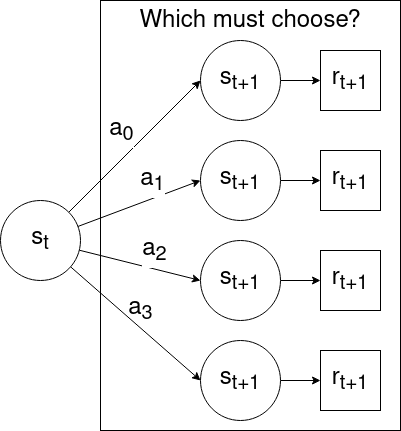

As mentioned before, the agent must iteratively decide what action must take. In this regard, a policy $\pi$ is a process that decides how to take an action.
In this tutorial, we will discuss the $\epsilon$-greedy policy.
In this policy, the e parameters balance between exploration and exploitation of the actions.

In the exploration stage, selects a random action with an $\epsilon$ probability of happening. By counterpart, with a 1 - $\epsilon$ probability, the exploitation stage selects an action using the information of the future expected reward. Being formulated as follows:

\begin{align}
a = 
\begin{cases}
    \text{random} & \text{with } \epsilon \text{ probability}\\
    \max V(s_t) & \text{with } 1 - \epsilon \text{ probability}\\
\end{cases}
\end{align}

In [ ]:
class TDAgent(RandomAgent):

    def __init__(self, actions, grid_size=(12, 4)):
        super().__init__(actions, grid_size)

    def get_epsilon_greedy_action(self, state, epsilon=0.99):
        # explotation
        if random.random() > epsilon:
            return np.argmax(self.Q_values[tuple(state)])
        # exploration
        return self.get_random_action()

    def get_action(self, state, epsilon=0.99):
        return self.get_epsilon_greedy_action(state, epsilon)    

## $Q$-learning algorithm
One widely studied policy update methodology is the $Q$-learning algorithm [6].
This algorithm implements an off-policy update scheme, improving the value function prediction.
For this algorithm, the value function is now a $Q$ values estimator for each state or state-action pair ($Q(s_t, a_t)$). The following formulation converge in an optimal policy $q*$:

One widely studied policy update methodology is the $Q$-learning algorithm [6].
This algorithm implements an off-policy update scheme, improving the value function prediction.
The value function is now a $Q$ values estimator for each state or state-action pair for this algorithm. The following formulation converges in an optimal policy q*:

\begin{align}
Q(s_t, a_t) = Q(s_t, a_t) + \alpha [r_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{align}

In [ ]:
def q_learning_update(agent, state, action, reward, next_state,
                      alpha=0.5, gamma=0.99):
    """This function intends to update the agent.Q_values with the Q-learning 
    algorithm.

    Args:
        agent (RL Agent class): an instance of the RL agent.
        state (list): a cell position from the environment.
        action (int): the selected action for the state.
        reward (int): value which represent the reward.
        next_state (list): a cell position from the environment after perform
                           the action.
        alpha (float): learning rate.
        gamma (float): long-term discounted reward value.
    
    Returns:
        np.ndarray: the updated agent.Q_values.

    This method is for you to implement following the Q-learning equation in
    the upper cell.
    """

    q_idx = tuple(state) + (action, )  # state-action pair index
    # obtain the Q values from the agent.Q_values
    current_q = ...
    # get the best Q value for the next state
    if next_state is None:
        best_q = 0
    else:
        best_q = ...
    
    # put back the td-error terms
    agent.Q_values[q_idx] += alpha * (...)
    
    return agent.Q_values

In [ ]:
#@title Testing Q-learning agent's performance

#@markdown Make sure you execute this cell to enable the widget!

n_episodes = 1000

@widgets.interact
def plot_tde_by_trial(episodes=widgets.IntSlider(value=10, min=0, max=n_episodes, step=5, description="Episodes #"),
                      epsilon=widgets.FloatSlider(value=0.5, min=0.05, max=1., step=0.05, description="Exploration rate: "),
                      alpha=widgets.FloatSlider(value=0.5, min=0.05, max=1., step=0.05, description="Learning rate: "),
                      gamma=widgets.FloatSlider(value=0.99, min=0.01, max=1., step=0.01, description="Long-term discount factor: ")):
    # environment instance
    environment = CliffWalking(12, 4)
    available_actions = list(range(environment.n_actions))
    agent = TDAgent(actions=available_actions)
    params = dict(epsilon=epsilon,
                alpha=alpha,
                gamma=gamma,
                function_update=q_learning_update)

    # training loop and results
    rewards, hist = training_loop(agent, environment, episodes, params=params,
                                log=False)
    best_ep, best_Q, best_path = hist['best']

    print('last best path, ep', best_ep)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_reward(rewards, ax=axes[0])
    plot_quiver_max_action(environment, hist['Q_values'], ax=axes[1])
    plot_path(environment, action_hist=best_path, ax=axes[2])

## Discussion

One advantage is that there is no need to have a labeled dataset for its training, relying only on the reward signal to optimize the agent overcome.
Additionally, RL algorithms can model complex robotics behaviors, which classic machine learning paradigms can not achieve. Different studies in diverse areas are researching more about these methods, being the most approximated methods to the natural learning process.

In the counterpart, RL methods still require too many samples to learn how to solve a given task. Some transfer-learning and human-interaction approaches [7-8] are current forms to reduce the experiences required in highly complex tasks. Another challenging gap is the real-world domain shifting, where the algorithm is more exposed to noise signals and other differences from a simulated environment.

### Some useful tools

- [OpenAI Gym](https://gym.openai.com/) [(GitHub)](https://github.com/openai/gym/): Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.
- [MushroomRL](https://mushroomrl.readthedocs.io/en/latest/) [(GitHub)](https://github.com/MushroomRL/mushroom-rl): MushroomRL is a Reinforcement Learning (RL) library developed to be a simple, yet powerful way to make RL and deep RL experiments. 
- DeepMind RL Course [(YouTube)](https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ).
- A Webots simulator scene with OpenAI Gym [(GitHub repository)](https://github.com/angel-ayala/webots-fire-scene).


## References

[1] Neftci, E.O., Averbeck, B.B. Reinforcement learning in artificial and biological systems. Nat Mach Intell 1, 133–143, (2019). https://doi.org/10.1038/s42256-019-0025-4

[2] Pavlov, P. I. Conditioned reflexes: an investigation of the physiological activity of the cerebral cortex. Annals of neurosciences, 17(3), 136, (2010).

[3] Sutton, R. S., and Barto, A. G. Reinforcement learning: An introduction. MIT press, (2018). http://incompleteideas.net/book/the-book-2nd.html 

[4] Glimcher, P. W. Understanding dopamine and reinforcement learning: The dopamine reward prediction error hypothesis. Proceedings of the National Academy of Sciences, 108 (Supplement 3) 15647-15654, (2011). http://doi.org/10.1073/pnas.1014269108

[5] Barto, A. G. Temporal difference learning. Scholarpedia, 2(11), 1604, (2007).

[6] Watkins, C. J., and Dayan, P. Q-learning. Machine learning, 8(3-4), 279-292, (1992).

[7] Cruz, F., Magg, S., Weber, C., and Wermter, S. Training agents with interactive reinforcement learning and contextual affordances. IEEE Transactions on Cognitive and Developmental Systems, 8(4), 271-284, (2016).

[8] Moreira, I., Rivas, J., Cruz, F., Dazeley, R., Ayala, A., and Fernandes, B. Deep Reinforcement Learning with Interactive Feedback in a Human–Robot Environment. Applied Sciences, 10(16), 5574, (2020).


# Are you interested in learn something more?
If you want to learn something extra about RL, you can start developing your own agent to solve the following gym environment named Cartpole-v1.
In this activity, you must consider that different data or numerical domains can represent the action and state in a problem.
Here you must replace the table-based Q-learning algorithm for an approximation function to process the state in the continuous domain. Same thing for the image array state, which is commonly processed by a convolutional neural network.

The following image illustrates the Cartpole problem.

<img src="https://d3i71xaburhd42.cloudfront.net/3dd67d8565480ddb5f3c0b4ea6be7058e77b4172/2-Figure1-1.png">

This problem belongs to the continuous domain. The main idea is to keep the pole vertically as long as possible, considering the problem is solved after 495 steps.
This problem can be formulated as an MDP as follows:

- __States__: represented as a vector with 4 components $< x, x', \theta, \theta' >$ corresponding to a) the car position respect the lane center; b) the car velocity; c) the pole angle of inclination; d) the pole angular velocity;
- __Actions__: represented as a binary value to specify the direction of the force $F$.
- __Transition function__: defined in the works of [Brownlee, 2005](https://researchbank.swinburne.edu.au/file/62a8df69-4a2c-407f-8040-5ac533fc2787/1/PDF%20(12%20pages).pdf) comprising:
  
  Diferential equation of pole movement:
\begin{align}
\ddot{\theta}_t = \frac{g \sin\theta_t + \cos\theta_t [\frac{- F_t - m_pl \dot{\theta}^2_t \sin\theta}{m_c + m_p}]}{l[\frac{4}{3} - \frac{m_p \cos^2\theta_t}{m_c + m_p}]}
\end{align}

  Diferential equation of care movement:
\begin{align}
\ddot{x}_t = \frac{F_t + m_p l [\dot{\theta}^2_t \sin\theta_t - \ddot{\theta}_t \cos\theta_t]}{m_c + m_p}
\end{align}

  where $m_c$ is the car mass, $m_p$ is the pole mass, $l$ is the pole length, $F$ the applied force, and $g$ gravitacional acceleration.

- __Reward function__: defined by
\begin{align}
r= 
\begin{cases}
1 & \text{pole inside the threshold angle.}\\
0 & \text{if surpass the threshold angle.}
\end{cases}
\end{align}

In [ ]:
#@title Libraries and helpers
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt # grafico
from gym.wrappers.monitor import load_results # resultados monitor
# visualización de entorno
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

%matplotlib inline
display = Display(visible=0, size=(400, 300))
display.start()

def show_render(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

In [ ]:
#@title Cartpole environment
environment = gym.make("CartPole-v1")
# MDP information
print(environment.action_space)  # action space config
print(environment.action_space.n)  # number of actions
print(environment.observation_space)  # observation space or state config
print(environment.observation_space.low)  # min values in the state vector
print(environment.observation_space.high)  # max values in the state vector

In [ ]:
episodes = 10
timesteps = 0

for e in range(episodios):
    state = environment.reset()
    ep_reward = 0
    end = False
    while not end:
        # render environment
        show_render(environment, timesteps, "EP {}".format(e))
        # random action selection
        action = ...
        # policy action selection
        # action = ...
        # ejecutar accion y observar nuevo estado
        next_state, reward, end, info = environment.step(action) 
        ep_reward += reward
        state = next_state
        timesteps += 1
    print('EP end', e, 'reward', ep_reward)

environment.close()